In [15]:
from datasets import load_from_disk
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchmetrics
from tqdm import tqdm
import torchaudio
from datasets import load_dataset, DatasetDict
import numpy as np
import random


SEED = 42
SAMPLE_RATE = 16000
BATCH_SIZE = 10
NUM_WORKERS = 24
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
print(f"Using device: {DEVICE}")

Using device: cuda


In [16]:
# dataset = load_dataset("Hibou-Foundation/big_ds_preprocessed_specto_noaugment_1_50g")
dataset = load_from_disk("../../dataset/ds_2_noaugment_test.hf")

In [17]:
dataset = dataset.with_format("torch", columns=["audio", "label"])
print("Dataset splits:", {k: v.shape for k, v in dataset.items()})

Dataset splits: {'train': (61543, 2), 'val': (7222, 2), 'test': (7220, 2)}


In [18]:
# -----------------------------
# Collate function with Mel computation
# -----------------------------
def collate_fn(batch):
    xs = [b["audio"] for b in batch]
    ys = [b["label"] for b in batch]

    xs = torch.stack(xs, dim=0).unsqueeze(1)
    ys = torch.tensor(ys, dtype=torch.float32).unsqueeze(1)

    return xs, ys




train_loader = DataLoader(dataset["train"], batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn)
valid_loader = DataLoader(dataset["val"], batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn)
test_loader = DataLoader(dataset["test"], batch_size=BATCH_SIZE, shuffle=False,num_workers=NUM_WORKERS, collate_fn=collate_fn)

In [19]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection to match dimensions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.prelu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # The "residual" connection
        out = self.prelu(out)
        return out

class AudioResNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Initial convolution (larger kernel can be good for spectrograms)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=(2, 1), padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.prelu = nn.PReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = ResidualBlock(32, 64, stride=2)
        self.layer2 = ResidualBlock(64, 128, stride=2)
        self.layer3 = ResidualBlock(128, 256, stride=2)

        self.pool2 = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.PReLU(),
            nn.Dropout(0.5), # Increase dropout
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.pool1(self.prelu(self.bn1(self.conv1(x))))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Use this model instead:
model = AudioResNet().to(DEVICE)

In [34]:
# Load model
model = AudioResNet().to(DEVICE)
model.load_state_dict(torch.load("best_model_2.pt", map_location=DEVICE))
model.eval()
print("Loaded best model and set to eval mode")

Loaded best model and set to eval mode


In [35]:
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        logits = model(x)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(y.cpu().numpy().flatten())

Testing: 100%|██████████| 722/722 [00:18<00:00, 38.53it/s]


In [36]:
# -----------------------------
# Metrics
# -----------------------------
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

df_results = pd.DataFrame({
    "true_label": all_labels,
    "pred_label": all_preds,
    "confidence": all_probs
})

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# print("\nClassification Report:")
# print(classification_report(all_labels, all_preds, target_names=dataset["train"].features["label"].names, digits=3))

cm = confusion_matrix(all_labels, all_preds)
print(cm)


Test Accuracy: 99.65%
[[5311   22]
 [   3 1884]]


In [37]:
# local_dataset = load_from_disk()

In [38]:
from matplotlib import pyplot as plt
ds_test_online = load_dataset("Usernameeeeee/drone_test", split="test")
ds_test_online2 = load_dataset("Usernameeeeee/drone_test_2", split="test")

def swap_labels(example):
    example["label"] = 1 - example["label"]   # flips 0 ↔ 1
    return example

ds_test_online = ds_test_online.map(swap_labels)
ds_test_online2 = ds_test_online2.map(swap_labels)

def convert_to_linear_spectrogram(batch):
    all_linear_db = []
    all_labels = []

    for audio, label in zip(batch["audio"], batch["label"]):
        data = np.array(audio["array"])

        # ---- FIX: convertir en float32 ----
        data = data.astype(np.float32)

        # Normalisation optionnelle (mais recommandée)
        # data = data / np.max(np.abs(data) + 1e-8)

        # Compute STFT
        stft = librosa.stft(data, n_fft=2048, hop_length=512)

        # Compute magnitude
        magnitude = np.abs(stft)

        # Convert to dB
        linear_db = librosa.amplitude_to_db(magnitude, ref=np.max)

        all_linear_db.append(linear_db)
        all_labels.append(label)

    return {
        "audio": all_linear_db,
        "label": all_labels,
    }

import librosa

NUM_PROC = 4
LABELS = dataset["train"].features["label"]

ds_test_online_spec = ds_test_online.map(
    convert_to_linear_spectrogram,
    batched=True,
    num_proc=NUM_PROC,
    batch_size=BATCH_SIZE,
    remove_columns=ds_test_online.column_names,
).with_format("torch")

ds_test_online2_spec = ds_test_online2.map(
    convert_to_linear_spectrogram,
    batched=True,
    num_proc=NUM_PROC,
    batch_size=BATCH_SIZE,
    remove_columns=ds_test_online2.column_names,
).with_format("torch")

test_loader1 = DataLoader(ds_test_online_spec, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn)

test_loader2 = DataLoader(ds_test_online2_spec, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn)

y_true1, y_pred1, y_true2, y_pred2 = [], [], [], []

with torch.no_grad():
    for x, y in tqdm(test_loader1, desc="Testing"):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        logits = model(x)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        y_pred1.extend(preds.cpu().numpy())
        y_true1.extend(y.cpu().numpy())

with torch.no_grad():
    for x, y in tqdm(test_loader2, desc="Testing"):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        logits = model(x)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        y_pred2.extend(preds.cpu().numpy())
        y_true2.extend(y.cpu().numpy())



'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /datasets/Usernameeeeee/drone_test/resolve/main/README.md (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7f20e4f28ad0>: Failed to resolve \'huggingface.co\' ([Errno -3] Temporary failure in name resolution)"))'), '(Request ID: 918c36ce-9372-4172-a62a-9f14b043f66a)')' thrown while requesting HEAD https://huggingface.co/datasets/Usernameeeeee/drone_test/resolve/main/README.md
Retrying in 1s [Retry 1/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /datasets/Usernameeeeee/drone_test/resolve/main/README.md (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7f224fbcf9d0>: Failed to resolve \'huggingface.co\' ([Errno -3] Temporary failure in name resolution)"))'), '(Request ID: 61248ba0-f363-4cb6-9c8f-7d8d5222954a)')' thrown while requesting HEAD https://huggingface.co/d

In [41]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

def compute_metrics(y_true, y_pred):
    y_true = np.array(y_true).astype(int)
    y_pred = np.array(y_pred).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    try:
        auc = roc_auc_score(y_true, y_pred)
    except:
        auc = float("nan")

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc,
        "confusion_matrix": cm,
    }

metrics1 = compute_metrics(y_true1, y_pred1)
metrics2 = compute_metrics(y_true2, y_pred2)



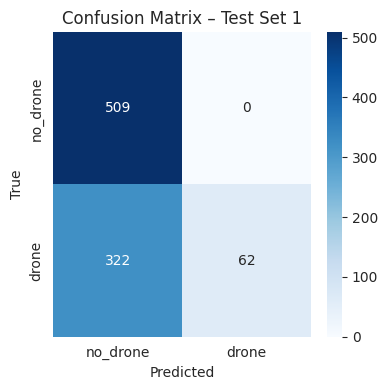

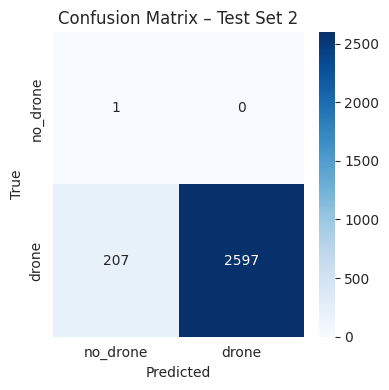

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

CLASS_NAMES = ["no_drone", "drone"]

def plot_confusion(cm, title):
    plt.figure(figsize=(4,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=CLASS_NAMES,
        yticklabels=CLASS_NAMES
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_confusion(metrics1["confusion_matrix"], "Confusion Matrix – Test Set 1")
plot_confusion(metrics2["confusion_matrix"], "Confusion Matrix – Test Set 2")
